In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

(0) Load

In [2]:
df_norway_exports = pd.read_parquet('df_nsc_2025_until_w18.parquet')
df_norway_exports = df_norway_exports.loc[df_norway_exports['Country'].isin(['TOTALT'])]
df_norway_exports['Week'] = df_norway_exports['Week'].astype('int32')
df_norway_exports['Year-Week'] = df_norway_exports['Year'].astype('string') + df_norway_exports['Week'].astype('string')
print(df_norway_exports.info())
df_norway_exports.head()

<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 0 to 8515
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      482 non-null    string 
 1   Volume (KG)  482 non-null    int64  
 2   Kr/kg        482 non-null    float64
 3   Week         482 non-null    int32  
 4   Product      482 non-null    string 
 5   Year         482 non-null    int64  
 6   Continent    482 non-null    object 
 7   Year-Week    482 non-null    string 
dtypes: float64(1), int32(1), int64(2), object(1), string(3)
memory usage: 32.0+ KB
None


,Country,Volume (KG),Kr/kg,Week,Product,Year,Continent,Year-Week
0,TOTALT,18407,67.23,1,FRESH WHOLE HON,2023,UNCLASSIFIED,20231
39,TOTALT,17635,72.05,2,FRESH WHOLE HON,2023,UNCLASSIFIED,20232
83,TOTALT,16648,95.19,3,FRESH WHOLE HON,2023,UNCLASSIFIED,20233
126,TOTALT,16973,90.30,4,FRESH WHOLE HON,2023,UNCLASSIFIED,20234
172,TOTALT,16932,93.11,5,FRESH WHOLE HON,2023,UNCLASSIFIED,20235


(1) Time Series Overall Exports Volume

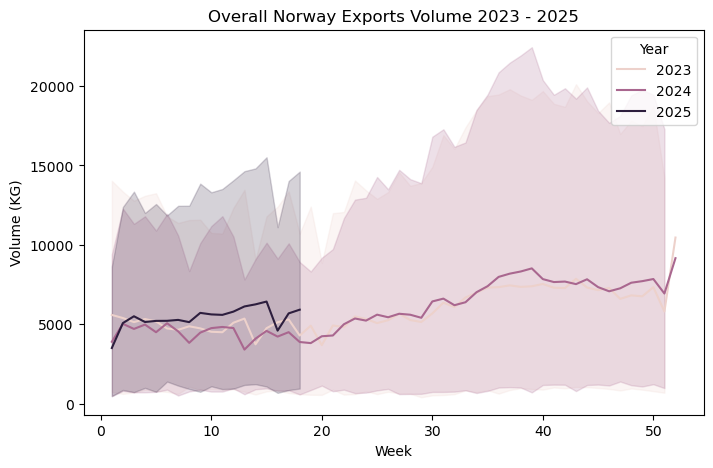

In [3]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_norway_exports, x='Week', y='Volume (KG)', hue='Year')
plt.title('Overall Norway Exports Volume 2023 - 2025')
plt.show()

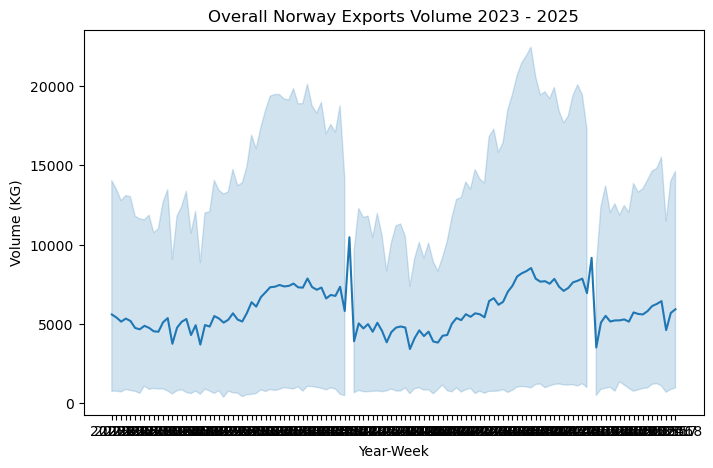

In [4]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_norway_exports, x='Year-Week', y='Volume (KG)')
plt.title('Overall Norway Exports Volume 2023 - 2025')
plt.show()

Según la tendencia de las exportaciones, es más parecido a un modelo aditivo que multiplicativo. Debido a que la tendencia no aumento desde un año a otro. 
Para efectos del análisis, utilizaremos los años 2023 y 2024, debido a que hasta la fecha, el 2025 ha tenido un comportamiento un poco anómalo, debido a las buenas condiciones biológicas, es decir, mejor cosecha.

(2) Time Series Decomposition

- Additive Model

In [5]:
df_norway_exports_2023_2024 = df_norway_exports.loc[df_norway_exports['Year'].isin([2023, 2024])]
df_norway_exports_2023_2024 = df_norway_exports_2023_2024.groupby(
                                                                    by=['Year', 'Week'], as_index=False
).agg(
        VolumeKG = ('Volume (KG)', 'sum')
).sort_values(by=['Year', 'Week'], ascending=True)

df_norway_exports_2023_2024['year_week_date'] = pd.to_datetime(
                                                                df_norway_exports_2023_2024['Year'].astype(str) 
                                                                + 
                                                                df_norway_exports_2023_2024['Week'].astype(str).str.zfill(2) 
                                                                + '1', 
                                                                format='%G%V%u')

df_volumes = df_norway_exports_2023_2024.set_index('year_week_date')
df_volumes = df_volumes['VolumeKG']

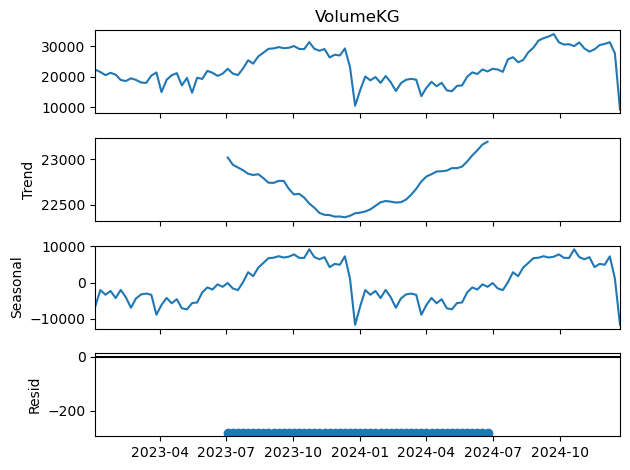

In [6]:
additive_decomposition = seasonal_decompose(df_volumes, model='additive', period=52)
additive_decomposition.plot()
plt.show()

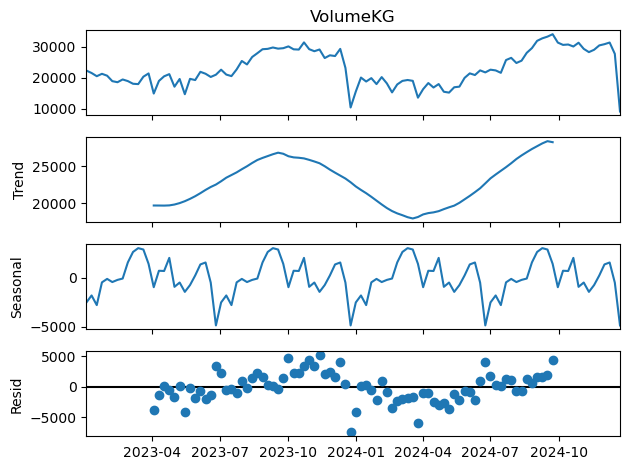

In [7]:
additive_decomposition = seasonal_decompose(df_volumes, model='additive', period=26)
additive_decomposition.plot()
plt.show()

In [8]:
resultado = adfuller(np.log(df_volumes)) # se convirtió en log para quitar el efecto no estacionario

print(f'Estadístico ADF: {resultado[0]}')
print(f'Valor p: {resultado[1]}')
print('Valores críticos:')
for clave, valor in resultado[4].items():
    print(f'  {clave}: {valor}')
    
# Interpretación básica
if resultado[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0)")
else:
    print("La serie no es estacionaria (no rechazamos H0)")

Estadístico ADF: -2.8102327029922014
Valor p: 0.05682690026667419
Valores críticos:
  1%: -3.4954932834550623
  5%: -2.8900369024285117
  10%: -2.5819706975209726
La serie no es estacionaria (no rechazamos H0)


In [11]:
resultado = adfuller(df_volumes.diff().dropna()) # se convirtió en log para quitar el efecto no estacionario

print(f'Estadístico ADF: {resultado[0]}')
print(f'Valor p: {resultado[1]}')
print('Valores críticos:')
for clave, valor in resultado[4].items():
    print(f'  {clave}: {valor}')
    
# Interpretación básica
if resultado[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0)")
else:
    print("La serie no es estacionaria (no rechazamos H0)")

Estadístico ADF: -6.789452989933727
Valor p: 2.3852493930386043e-09
Valores críticos:
  1%: -3.4968181663902103
  5%: -2.8906107514600103
  10%: -2.5822770483285953
La serie es estacionaria (rechazamos H0)


### Conclusión: 
Las exportaciones de noruega a nivel anual, poseen una tendencia en forma de U invertida, debido a que existe una baja durante la primera parte del año, para luego ser aumenta en segunda parte, por mejores condiciones del mercado, el cual hace que la planning del cultivo sea para cosechar en esa parte. Por lo tanto tiene sentido la forma de U. 
Y a nivel semestral, que es el otro horizonte que decidí descomponer, consta de dos Ues. una normal y la segunda invertida. Reflejando que al principio del año la cosecha tiene a la baja, debido a que no es un período de fuerte demana, para luego aumentar (u invertida) en donde las condiciones de mercado llegan a su peak. Los dos ciclos tienen un inicio y fin, por eso se reflejan en forma de U. 
Los residuos, a nivel anual, son prácticamente nulos, debido a que no existe una mayor diferencia entre un año y otro, sería mejor si tuviese a lo menos 5 años de exportación. Y, a nivel semestral, se ven un poco distorsionados, en donde debe ser por fechas puntuales del comercio, como vacaciones, festividades o algún evento biológico, etc. 
Y desde un punto de vista estadístico, tiene sentido que no sea estacionaria (test ADF), debido a que existen fluctuaciones por eventos del negocio (vacaciones, festividades, etc). Y al quitarle la tendencia, refleja lo mismo.

PS: No dejé los resulados con TSA, porque dieron horrible.